In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import QM9

from dataset import create_QM9_pyg_datasets
from models import GCNModel, GATModel, GINModel, MPNNModel, SchNetModel, DimeNetPlusPlusModel


In [35]:
selected_model_name = "MPNN"     # "GCN", "GAT", "GIN", "MPNN", "SchNet", "DimeNet"
hcs = 128
num_layers = 2
heads = 16
dropout = 0.5

num_epochs = 100
patience = 5
best_model_path = f'./best_{selected_model_name}_model.pth' # Path to save the best model

# For HOMO and LUMO (indices 2 and 3 in QM9's 19 targets)
# target_idx = [2, 3] # HOMO at index 2, LUMO at index 3
# target_idx = [0,1,2,3,4]
# target_idx = [7,8,9,10]
# target_idx = [12,13,14,15]
target_idx = [16,17,18]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Data Loading ---
# train_graphs, val_graphs, test_graphs are lists of PyG Data objects
# y_train, y_val, y_test are tensors of the selected targets, useful for knowing num_targets
train_graphs, val_graphs, test_graphs = create_QM9_pyg_datasets(
    train_ratio = 0.8,
    val_ratio = 0.1,
    test_ratio = 0.1,
    # subset_size = 50000,
)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)


Using device: cuda
Original QM9 dataset size: 130831
Train PyG graphs: 104664
Validation PyG graphs: 13083
Test PyG graphs: 13084


In [37]:
# --- Determine Model Input/Output Sizes ---
# Get number of node and edge features from the dataset
# Load a temporary full dataset instance just for these properties if needed,
# or get from the first graph if the subset is representative.
if train_graphs:
    num_node_features = train_graphs[0].num_node_features
    num_edge_features = train_graphs[0].num_edge_features
else: # Fallback if subset is empty, though create_QM9_pyg_datasets should handle this
    temp_dataset = QM9(root='./data/QM9')
    num_node_features = temp_dataset.num_node_features
    num_edge_features = temp_dataset.num_edge_features
    del temp_dataset

num_targets = len(target_idx)

print(f"Number of node features: {num_node_features}")
print(f"Number of edge features: {num_edge_features}") # Relevant for MPNN
print(f"Number of targets: {num_targets}")

# --- Model Initialization (Choose one model to train) ---

if selected_model_name == "GCN":
    model = GCNModel(num_node_features=num_node_features, hidden_channels=hcs, num_targets=num_targets, num_layers=num_layers, dropout_rate=dropout).to(device)
elif selected_model_name == "GAT":
    model = GATModel(num_node_features=num_node_features, hidden_channels=hcs, num_targets=num_targets, heads=heads, num_layers=num_layers, dropout_rate=dropout).to(device)
elif selected_model_name == "GIN":
    model = GINModel(num_node_features=num_node_features, hidden_channels=hcs, num_targets=num_targets, num_layers=num_layers, dropout_rate=dropout, train_eps=True).to(device)
elif selected_model_name == "MPNN":
    model = MPNNModel(num_node_features=num_node_features, num_edge_features=num_edge_features, hidden_channels=hcs, num_targets=num_targets, num_layers=num_layers, dropout_rate=dropout).to(device)
elif selected_model_name == "SchNet":
    # SchNet uses atomic numbers (z) and positions (pos), not num_node_features directly for its core.
    model = SchNetModel(num_targets=num_targets, hidden_channels=hcs).to(device)
elif selected_model_name == "DimeNet":
    model = DimeNetPlusPlusModel(num_targets=num_targets, hidden_channels=hcs).to(device)
else:
    raise ValueError(f"Unknown model name: {selected_model_name}")

print(f"\nSelected model: {selected_model_name}")
print(model)

# --- Optimizer and Loss Function ---
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

Number of node features: 11
Number of edge features: 4
Number of targets: 3

Selected model: MPNN
MPNNModel(
  (convs): ModuleList(
    (0): NNConv(11, 128, aggr=mean, nn=Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=1408, bias=True)
    ))
    (1): NNConv(128, 128, aggr=mean, nn=Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=16384, bias=True)
    ))
  )
  (set2set): Set2Set(128, 256)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)



Starting training for MPNN...
Early stopping patience: 5 epochs. Best model will be saved to: ./best_MPNN_model.pth
Epoch 01/100, Train Loss: 1396092.6070, Val Loss: 26.8791
    Validation loss improved. Saved new best model to ./best_MPNN_model.pth
Epoch 02/100, Train Loss: 1396098.3718, Val Loss: 26.8260
    Validation loss improved. Saved new best model to ./best_MPNN_model.pth
Epoch 03/100, Train Loss: 1396097.8292, Val Loss: 26.7875
    Validation loss improved. Saved new best model to ./best_MPNN_model.pth
Epoch 04/100, Train Loss: 1396097.2591, Val Loss: 26.7712
    Validation loss improved. Saved new best model to ./best_MPNN_model.pth
Epoch 05/100, Train Loss: 1396080.1001, Val Loss: 27.2193
    Validation loss did not improve for 1 epoch(s).
Epoch 06/100, Train Loss: 1396090.2424, Val Loss: 26.8109
    Validation loss did not improve for 2 epoch(s).
Epoch 07/100, Train Loss: 1395936.4670, Val Loss: 28.1554
    Validation loss did not improve for 3 epoch(s).
Epoch 08/100, Tra

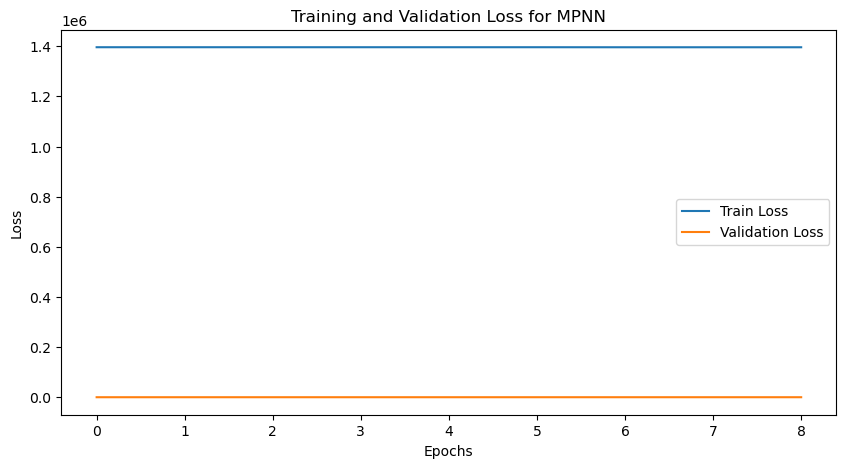

In [38]:
def train_epoch(model, loader, optimizer, criterion, device, target_indices_list, model_type):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass depends on the model type
        if model_type in ["GCN", "GAT", "GIN"]:
            out = model(data.x, data.edge_index, data.batch)
        elif model_type == "MPNN":
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        elif model_type in ["SchNet", "DimeNet"]:
            out = model(data.z, data.pos, data.batch)
        else:
            raise ValueError(f"Unsupported model type for training: {model_type}")

        # Select the correct targets from data.y
        # data.y is typically [batch_size, 1, num_all_qm9_targets]
        # We need to make it [batch_size, num_selected_targets]
        actual_y = data.y.squeeze(1)[:, target_indices_list] # Squeeze out the middle dim, then select
        
        loss = criterion(out, actual_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate_epoch(model, loader, criterion, device, target_indices_list, model_type):
    model.eval()
    total_loss = 0
    for data in loader:
        data = data.to(device)

        if model_type in ["GCN", "GAT", "GIN"]:
            out = model(data.x, data.edge_index, data.batch)
        elif model_type == "MPNN":
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        elif model_type in ["SchNet", "DimeNet"]:
            out = model(data.z, data.pos, data.batch)
        else:
            raise ValueError(f"Unsupported model type for evaluation: {model_type}")
            
        actual_y = data.y.squeeze(1)[:, target_indices_list]
        loss = criterion(out, actual_y)
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# --- Training ---
train_losses = []
val_losses = []

# Early Stopping and Best Model Saving parameters
early_stopping_counter = 0
best_val_loss = float('inf')

print(f"\nStarting training for {selected_model_name}...")
print(f"Early stopping patience: {patience} epochs. Best model will be saved to: {best_model_path}")

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_idx, selected_model_name)
    val_loss = evaluate_epoch(model, val_loader, criterion, device, target_idx, selected_model_name)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch:02d}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for improvement in validation loss for early stopping and best model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0 # Reset counter
        # Save the best model
        # torch.jit.script(model).save(best_model_path)
        torch.save(model.state_dict(), best_model_path)
        print(f'    Validation loss improved. Saved new best model to {best_model_path}')
    else:
        early_stopping_counter += 1
        print(f'    Validation loss did not improve for {early_stopping_counter} epoch(s).')

    if early_stopping_counter >= patience:
        print(f'\nEarly stopping triggered after {epoch} epochs due to no improvement in validation loss for {patience} epochs.')
        break

print("\nTraining finished.")

# --- Final Evaluation on Test Set ---
# Load the best model saved during training for final evaluation
if os.path.exists(best_model_path):
    print(f"\nLoading best model from {best_model_path} for final evaluation...")
    # model = torch.jit.load(best_model_path).to(device)
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.to(device)
    model.eval()
else:
    print("\nWarning: No best model was saved (or path is incorrect). Evaluating with the last model state.")

test_loss = evaluate_epoch(model, test_loader, criterion, device, target_idx, selected_model_name)
print(f'Final Test Loss for {selected_model_name} (using best model): {test_loss:.4f}')

# It's good practice to also plot train_losses and val_losses to visualize training
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
# plt.ylim(0, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss for {selected_model_name}')
plt.legend()
plt.show()

Final Test Loss for GCN (using best model): 0.2292  
Final Test Loss for GAT (using best model): 0.5043 - 0.4468 with optimalization  
Final Test Loss for GIN (using best model): 0.1679  
Final Test Loss for MPNN (using best model): 0.0854  

GIN - néhol a val loss nagyon ugrált és voltak nagyon magas értékek  
hiddenchannels: 128, layers: 1 - Final Test Loss for GIN (using best model): 0.1613  
hiddenchannels: 64, layers: 1  - Final Test Loss for GIN (using best model): 0.2000  
hiddenchannels: 64, layers: 2  - Final Test Loss for GIN (using best model): 0.1215  
hiddenchannels: 64, layers: 3  - Final Test Loss for GIN (using best model): 0.0960  
hiddenchannels: 128, layers: 3 - Final Test Loss for GIN (using best model): 0.1063  
train eps true  
hiddenchannels: 128, layers: 3 - Final Test Loss for GIN (using best model): 0.0716  

MPNN  
hiddenchannels: 64, layers: 1 - Final Test Loss for MPNN (using best model): 0.0741  
hiddenchannels: 64, layers: 2 - Final Test Loss for MPNN (using best model): 0.0637  
hiddenchannels: 64, layers: 3 - Final Test Loss for MPNN (using best model): 0.0850  
hiddenchannels: 128, layers: 2 - Final Test Loss for MPNN (using best model): 0.0438  

First 5 property with the same settings  
Final Test Loss for MPNN (using best model): 1.1443  

12-15  
Final Test Loss for MPNN (using best model): 20.8782

16-18  
Final Test Loss for MPNN (using best model): 1.6960

10 property 0-9 idxs - not learning well  
Final Test Loss for MPNN (using best model): 1247389.6569

property 7-10 idxs  
Final Test Loss for MPNN (using best model): 2371023.0772